In [90]:
import pandas as pd
import numpy as np
from os import path as osp
import json
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
ROOT_DIR = osp.dirname(osp.dirname(osp.abspath('.')))  # 项目根目录

In [92]:
file_path = 'companies_news_info_v2.txt'

In [93]:
data_lst = []
data_path = osp.join(ROOT_DIR, 'data', 'THUCNews', file_path)

# ABS长度分析

In [94]:
with open(data_path, mode='r', encoding='utf-8') as fr:
    lines = fr.readlines()
    for line in lines:
        eles = line.strip().split('\u0001')
        data_lst.append(len(eles[1]))

In [95]:
df = pd.DataFrame(data_lst)

In [96]:
df.columns = ['length']

In [97]:
df

,length
0,338
1,364
2,317
3,830
4,298
...,...
243,678
244,297
245,776
246,1801


In [98]:
df['length'].describe()

count     248.000000
mean      709.758065
std       573.299017
min       115.000000
25%       307.250000
50%       479.000000
75%       921.500000
max      3564.000000
Name: length, dtype: float64

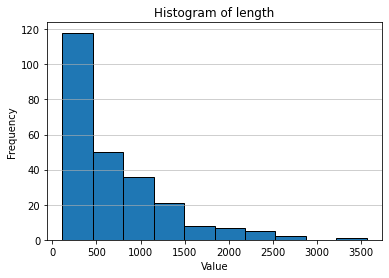

In [99]:
plt.hist(df['length'], bins=10, edgecolor='black') # bins 参数控制柱子数量
plt.title('Histogram of length')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75) # 添加网格线
plt.show()

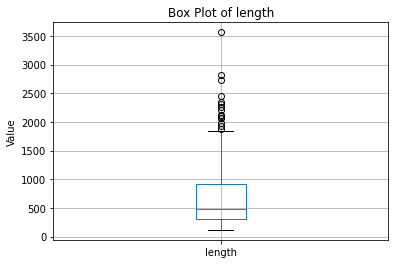

In [100]:
df.boxplot(column='length')
plt.title('Box Plot of length')
plt.ylabel('Value')
plt.show()

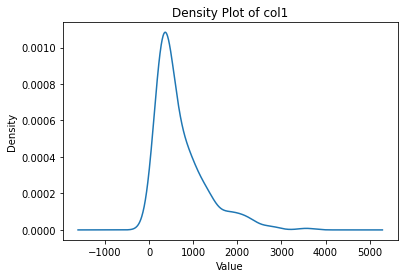

In [101]:
df['length'].plot(kind='kde')
plt.title('Density Plot of col1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

Peak Density X-value (Approximate Mode) for 'length': 374.55


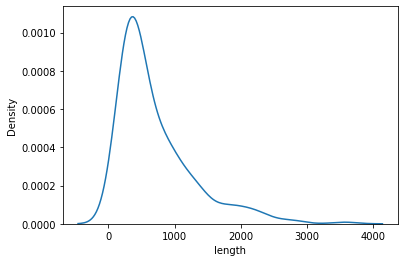

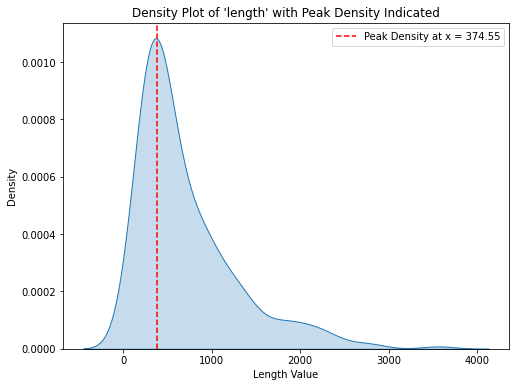

In [102]:
# Generate KDE data for 'length' column
kde = sns.kdeplot(data=df['length'],
                  clip_on=False).lines[0]
kde_x, kde_y = kde.get_data()

# Find the index of the maximum density value
max_density_index = np.argmax(kde_y)

# Get the x-value at the peak density
peak_x_value = kde_x[max_density_index]

print(f"Peak Density X-value (Approximate Mode) for 'length': {peak_x_value:.2f}")

# (Optional) Visualize the peak on the density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df['length'], fill=True)
plt.axvline(peak_x_value, color='red', linestyle='--', label=f'Peak Density at x = {peak_x_value:.2f}')
plt.legend()
plt.title("Density Plot of 'length' with Peak Density Indicated")
plt.xlabel('Length Value')
plt.ylabel('Density')
plt.show()

In [103]:
percentile_25 = df['length'].quantile(0.25)
percentile_75 = df['length'].quantile(0.75)
iqr_range = (percentile_25, percentile_75)

print(f"25th Percentile of 'length': {percentile_25:.2f}")
print(f"75th Percentile of 'length': {percentile_75:.2f}")
print(f"Interquartile Range (IQR) for 'length': {iqr_range}")

# Example for 10th to 90th percentile range
percentile_10 = df['length'].quantile(0.10)
percentile_90 = df['length'].quantile(0.90)
p90_range = (percentile_10, percentile_90)
print(f"10th Percentile of 'length': {percentile_10:.2f}")
print(f"90th Percentile of 'length': {percentile_90:.2f}")
print(f"10th-90th Percentile Range for 'length': {p90_range}")

25th Percentile of 'length': 307.25
75th Percentile of 'length': 921.50
Interquartile Range (IQR) for 'length': (307.25, 921.5)
10th Percentile of 'length': 233.70
90th Percentile of 'length': 1412.00
10th-90th Percentile Range for 'length': (233.7, 1412.0000000000002)


# length analysis

In [104]:
data_lst = []
with open(data_path, mode='r', encoding='utf-8') as fr:
    lines = fr.readlines()
    for line in lines:
        eles = line.strip().split('\u0001')
        data_lst.append((eles[0], eles[1]))

In [105]:
df = pd.DataFrame(data_lst)
df.columns = ['summary', 'text']

In [106]:
df['summary_length'] = df['summary'].apply(len)
df['text_length'] = df['text'].apply(len)
df['compress_ratio'] = df['summary_length'] / df['text_length']  

In [107]:
df['summary_length']

0       81
1       93
2       86
3      137
4      144
      ... 
243    137
244    161
245     90
246    137
247     96
Name: summary_length, Length: 248, dtype: int64

In [108]:
df['text_length']

0       338
1       364
2       317
3       830
4       298
       ... 
243     678
244     297
245     776
246    1801
247     401
Name: text_length, Length: 248, dtype: int64

In [109]:
df['compress_ratio'].apply(lambda x: str(round(x * 100, 1)) + '%')

0      24.0%
1      25.5%
2      27.1%
3      16.5%
4      48.3%
       ...  
243    20.2%
244    54.2%
245    11.6%
246     7.6%
247    23.9%
Name: compress_ratio, Length: 248, dtype: object

In [110]:
df['summary_length'].describe()

count    248.000000
mean     122.443548
std       38.530666
min       39.000000
25%       93.000000
50%      122.500000
75%      148.250000
max      245.000000
Name: summary_length, dtype: float64

In [111]:
df['text_length'].describe()

count     248.000000
mean      709.758065
std       573.299017
min       115.000000
25%       307.250000
50%       479.000000
75%       921.500000
max      3564.000000
Name: text_length, dtype: float64

In [112]:
df['compress_ratio'].describe()

count    248.000000
mean       0.262674
std        0.159976
min        0.027203
25%        0.137267
50%        0.234513
75%        0.361709
max        0.775510
Name: compress_ratio, dtype: float64

# 关键词分析

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba

def tfidf_keyword_extraction_multiple(texts, top_k=10):
    """
    Extracts top keywords from multiple texts using TF-IDF.

    Args:
        texts (list): A list of input texts (strings).
        top_k (int): Number of top keywords to extract PER DOCUMENT.

    Returns:
        dict: A dictionary where keys are document indices and values are lists of top keywords for each document.
    """
    processed_texts = []
    for text in texts:
        words = jieba.lcut(text)
        processed_texts.append(" ".join(words))

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(processed_texts) # Now fit on ALL texts

    all_keywords = {} # Dictionary to store keywords for each document
    feature_names = vectorizer.get_feature_names()

    for i, text in enumerate(texts): # Iterate through each document
        tfidf_scores = tfidf_matrix[i].toarray().flatten() # Get scores for document i
        keywords_scores = list(zip(feature_names, tfidf_scores))
        keywords_scores = sorted(keywords_scores, key=lambda x: x[1], reverse=True)
        top_keywords = [keyword for keyword, score in keywords_scores[:top_k]]
        all_keywords[i] = top_keywords # Store keywords for document i

    return all_keywords

In [114]:
 pip install scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [115]:
# text keyword analysis
text_keywords_tfidf = tfidf_keyword_extraction_multiple([ele[1] for ele in data_lst])
for i, keywords in text_keywords_tfidf.items():
    print(f"TF-IDF Keywords for Document {i+1}:", keywords)

TF-IDF Keywords for Document 1: ['amd', 'meta', '基站', '名为', '运营商', '计划', 'facebook', '移动', '开展', '母公司']
TF-IDF Keywords for Document 2: ['石油', '壳牌', '卢克', '润滑油', '俄罗斯', '有限责任', '加油站', '股份', '100', '收购']
TF-IDF Keywords for Document 3: ['水电站', 'ge', 'itaipu', '巴拉圭', '技术升级', '通用电气', '项目', '签约', '巴西', '升级']
TF-IDF Keywords for Document 4: ['西门子', '欧元', '俄罗斯', '增长', '订单', '主要', '同比', '业务', '去年同期', 'mobility']
TF-IDF Keywords for Document 5: ['波音公司', '季度', '交货', '787', '客机', '波音', '延迟', '质量', '问题', '12']
TF-IDF Keywords for Document 6: ['软银', '财年', 'fund', 'vision', '万亿日元', '科技股', '132', '另据', '日本共同社', '投资']
TF-IDF Keywords for Document 7: ['苹果', 'apple', 'pay', '钱包', '欧盟', '消费者', '竞争', '移动', 'nfc', '排他性']
TF-IDF Keywords for Document 8: ['施耐德', '电气', '持续', '第一季度', '发展', 'ssi', '基金会', '战略', '指数', '展览']
TF-IDF Keywords for Document 9: ['数据中心', '华为', '金融', '能源', '领域', '军团', '数据', '签约', '绿色', '中金']
TF-IDF Keywords for Document 10: ['mrna', '多利斯', '西门子', '工艺', '自动化', '解决方案', '信息化', '无纸化', '携手',

In [116]:
# summary keyword analysis
summary_keywords_tfidf = tfidf_keyword_extraction_multiple([ele[0] for ele in data_lst])
for i, keywords in summary_keywords_tfidf.items():
    print(f"TF-IDF Keywords for Document {i+1}:", keywords)

TF-IDF Keywords for Document 1: ['meta', '发达国家', '基站', '宽带', '宽频', '普及', 'amd', '世界各地', '计划', '更加']
TF-IDF Keywords for Document 2: ['壳牌', '卢克', '石油', '发展', '收购', '优质', '分销', '劳动', '多名', '新东家']
TF-IDF Keywords for Document 3: ['水电站', '之久', '使用量', '巴拉圭', '技术升级', '投运', '签约', '耗时', '通用电气', '14']
TF-IDF Keywords for Document 4: ['财年', '同比', '俄罗斯', '西门子', '净利润', '由于', '第二', '2022', '增长', '关闭']
TF-IDF Keywords for Document 5: ['季度', '亏损', '波音', '连续', '出现', '今年', '139', '91', '不过关', '交货']
TF-IDF Keywords for Document 6: ['132', '财年', '历史', '软银', '亏损', '亿美元', '185', '2002', '不良', '债权']
TF-IDF Keywords for Document 7: ['苹果', '欧盟', 'apple', 'pay', '阻碍', '认为', '支付', '确保', '消费者', '欧洲']
TF-IDF Keywords for Document 8: ['持续', '第一季度', '实现', '00', 'ssi', '分为', '总得', '成果', '第二年', '良好开端']
TF-IDF Keywords for Document 9: ['数据中心', '综合', '能源管理', '智慧', '合作', '绿色', '能源', '中金', '交流', '光伏']
TF-IDF Keywords for Document 10: ['mrna', '多利斯', '深化', '助力', '西门子', '解决方案', '合作', 'cgt', '信息化', '和赛']
TF-IDF Keywords for

In [117]:
# 对比分析summary和text关键词的交叉度
intersection_rate = []
for i in range(len(summary_keywords_tfidf)):
    summary_keyword_set = set(summary_keywords_tfidf[i])
    text_keyword_set = set(text_keywords_tfidf[i])
    intersection_count = len(text_keyword_set.intersection(summary_keyword_set))
    intersection_rate.append(intersection_count / len(text_keywords_tfidf[i]))
intersection_rate_df = pd.DataFrame(intersection_rate)
intersection_rate_df.columns = ['intersection_rate']

In [118]:
intersection_rate_df.describe()

,intersection_rate
count,248.000000
mean,0.462097
std,0.171014
min,0.000000
25%,0.300000
50%,0.500000
75%,0.600000
max,0.900000


# word cloud

In [119]:
# pip install wordcloud==1.8.2.2 --user

In [120]:
# pip install Pillow

In [121]:
from wordcloud import WordCloud
import jieba
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

In [122]:
def generate_wordcloud(text, output_file="wordcloud.png", mask_file=None, font_path=r"simhei.ttf"):
    """
    Generates a word cloud from Chinese text.

    Args:
        text (str): The input Chinese text.
        output_file (str): Path to save the generated word cloud image.
        mask_file (str, optional): Path to a mask image file (for custom shapes). Defaults to None.
        font_path (str, optional): Path to a font file that supports Chinese characters. Defaults to "simhei.ttf".
    """

    # 1. 中文分词 (Chinese Word Segmentation)
    wordlist_jieba = jieba.lcut(text)
    wl_space_split = " ".join(wordlist_jieba)

    # 2. 设置词云参数 (Configure WordCloud)
    #  这里需要根据你的实际情况调整参数
    wc = WordCloud(
        background_color="white", # 背景颜色
        max_words=200,           # 最大词数
        font_path=font_path,    # 字体路径 (需要支持中文的字体)
        width=800,              # 宽度
        height=600,             # 高度
        margin=2,               # 词语边缘距离
        max_font_size=150,      # 最大字体大小
        random_state=42,        # 随机种子，保证每次运行结果一致
        mask=None,              # 默认矩形，可以自定义词云形状
        stopwords=None,         # 停用词，这里不设置停用词
        scale=1.5               # 清晰度，值越大越清晰
    )

    #  如果需要自定义词云形状，可以加载mask图片
    if mask_file:
        mask = np.array(Image.open(mask_file))
        wc.mask = mask

    # 3. 生成词云 (Generate Word Cloud)
    my_wordcloud = wc.generate(wl_space_split)

    # 4. 显示词云图片 (Display Word Cloud Image)
    plt.imshow(my_wordcloud)
    plt.axis("off") # 关闭坐标轴
    plt.show()

    # 5. 保存词云图片 (Save Word Cloud Image)
    wc.to_file(output_file)

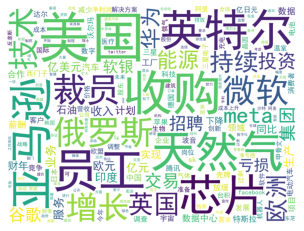

In [123]:
summary_keywords_lst = [' '.join(v) for _, v in summary_keywords_tfidf.items()]
text = ' '.join(summary_keywords_lst)
output_file = "summary_keywords_wordcloud.png" # 输出文件名
generate_wordcloud(text, output_file)

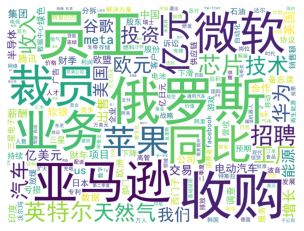

In [124]:
text_keywords_lst = [' '.join(v) for _, v in text_keywords_tfidf.items()]
text = ' '.join(text_keywords_lst)
output_file = "text_keywords_wordcloud.png" # 输出文件名
generate_wordcloud(text, output_file)

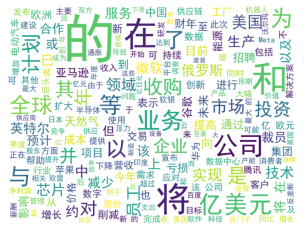

In [125]:
summary_lst = [i[0] for i in data_lst]
text = ' '.join(summary_lst)
output_file = "summary_wordcloud.png" # 输出文件名
generate_wordcloud(text, output_file)

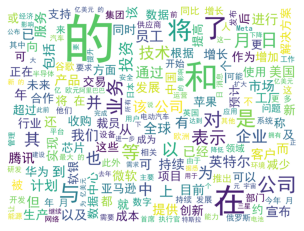

In [126]:
text_lst = [i[1] for i in data_lst]
text = ' '.join(text_lst)
output_file = "text_wordcloud.png" # 输出文件名
generate_wordcloud(text, output_file)

# keywords NER analysis

In [127]:
# pip install -U  wheel -i https://pypi.tuna.tsinghua.edu.cn/simple

In [128]:
# pip install -U spacy -i https://pypi.tuna.tsinghua.edu.cn/simple

In [129]:
# pip install spacy-pkuseg  -U

In [130]:
# pip install zh_core_web_sm-3.8.0.tar.gz

In [131]:
def tfidf_keyword_extraction_with_ner(keywords_lst, spacy_model="zh_core_web_sm"):
    # 3. 加载 spaCy 中文模型 (Load spaCy Chinese Model)
    nlp = spacy.load(spacy_model)

    # 4. 对关键词进行 NER 分析 (Perform NER Analysis on Keywords)
    keywords_ner_labels = {}
    for keyword in keywords_lst:
        doc = nlp(keyword) # Process keyword with spaCy
        if doc.ents: # Check if any entities are recognized
            # For simplicity, take the label of the first entity if multiple are found (keywords are usually short)
            ner_label = doc.ents[0].label_ # Get NER label
        else:
            ner_label = "NONE" # If no entity recognized, label as "NONE"
        keywords_ner_labels[keyword] = ner_label # Store keyword and its NER label

    return keywords_ner_labels

In [133]:
summary_keywords_lst = [v for _, v in summary_keywords_tfidf.items()]

In [134]:
for i in range(len(summary_keywords_lst)):
    keywords_ner_labels = tfidf_keyword_extraction_with_ner(summary_keywords_lst[i])
    print(keywords_ner_labels)

{'meta': 'NONE', '发达国家': 'NONE', '基站': 'NONE', '宽带': 'NONE', '宽频': 'NONE', '普及': 'NONE', 'amd': 'NONE', '世界各地': 'NONE', '计划': 'NONE', '更加': 'NONE'}
{'壳牌': 'ORG', '卢克': 'NONE', '石油': 'NONE', '发展': 'NONE', '收购': 'NONE', '优质': 'NONE', '分销': 'NONE', '劳动': 'NONE', '多名': 'NONE', '新东家': 'NONE'}
{'水电站': 'NONE', '之久': 'NONE', '使用量': 'NONE', '巴拉圭': 'GPE', '技术升级': 'NONE', '投运': 'NONE', '签约': 'NONE', '耗时': 'NONE', '通用电气': 'ORG', '14': 'NONE'}
{'财年': 'NONE', '同比': 'NONE', '俄罗斯': 'GPE', '西门子': 'ORG', '净利润': 'NONE', '由于': 'NONE', '第二': 'ORDINAL', '2022': 'CARDINAL', '增长': 'NONE', '关闭': 'NONE'}
{'季度': 'NONE', '亏损': 'NONE', '波音': 'PRODUCT', '连续': 'NONE', '出现': 'NONE', '今年': 'DATE', '139': 'CARDINAL', '91': 'CARDINAL', '不过关': 'NONE', '交货': 'NONE'}
{'132': 'NONE', '财年': 'NONE', '历史': 'NONE', '软银': 'NONE', '亏损': 'NONE', '亿美元': 'MONEY', '185': 'NONE', '2002': 'DATE', '不良': 'NONE', '债权': 'NONE'}
{'苹果': 'NONE', '欧盟': 'ORG', 'apple': 'LOC', 'pay': 'NONE', '阻碍': 'NONE', '认为': 'NONE', '支付': 'NONE', '确保': 'NONE'

In [ ]:
print(summary_keywords_lst)

# Sentence Analysis

In [84]:
def text_segmentate(text, maxlen, seps=u'\n。！？；：，', strips=None):
    """
    将文本按照标点符号划分为若干个短句，使得每个短句的长度不超过maxlen个字符
    注：每个短句中可能存在标点符号
    Args:
        text: 文章
        maxlen: 短句的最大字符长度
        seps: 分隔符
        strips: 首尾特定字符列表

    Returns:

    """
    text = text.strip().strip(strips)
    if seps and len(text) > maxlen:
        pieces = text.split(seps[0])
        pieces = [p.strip() for p in pieces]
        text, texts = '', []
        for i, p in enumerate(pieces):
            if text and p and len(text) + len(p) > maxlen - 1:
                texts.extend(text_segmentate(text, maxlen, seps[1:], strips))
                text = ''
            if i + 1 == len(pieces):
                text = text + p
            else:
                text = text + p + seps[0]
        if text:
            texts.extend(text_segmentate(text, maxlen, seps[1:], strips))
        return texts
    else:
        return [text]

In [137]:
def sentence_length(text):
    """
    统计句子数
    """
    sentence_lengths = []
    sentences = text_segmentate(text, 32)
    return len(sentences)

In [ ]:
    for sentence in sentences:
        sentence_lengths.append(len(sentence))

    return sentence_lengths

In [142]:
df['text_sentence_lengths'] = df['text'].apply(sentence_length)
df['summary_sentence_lengths'] = df['summary'].apply(sentence_length)

In [143]:
df['text_sentence_lengths'].describe()

count    248.000000
mean      29.294355
std       23.954031
min        4.000000
25%       12.750000
50%       20.000000
75%       40.000000
max      126.000000
Name: text_sentence_lengths, dtype: float64

In [144]:
df['summary_sentence_lengths'].describe()

count    248.000000
mean       5.125000
std        1.746164
min        1.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       12.000000
Name: summary_sentence_lengths, dtype: float64

# Summary Appearance Analysis

In [220]:
def visualize_sentence_position_distribution(sentence_positions, output_file="sentence_position_distribution.png"):
    sns.set_style("darkgrid")

    # 设置图形大小
    plt.figure(figsize=(30, 12))
    
    # 绘制直方图
    sns.histplot(sentence_positions, bins=range(1, max(sentence_positions + [10]) + 1), 
                 discrete=True, stat='density', color='skyblue', alpha=0.6, label='Histogram')
    
    # 添加分布曲线，限制范围从1 开始
    sns.kdeplot(sentence_positions, color='red', linewidth=2, label='Density Curve', 
                clip=(1, max(sentence_positions) + 1),  # 限制 KDE 曲线的范围
                bw_adjust=0.5)  # 调整带宽，减少过分平滑
    
    # 设置标题和标签
    plt.title('Distribution of Summary Sentence Positions in Original Articles', fontsize=24)
    plt.xlabel('Sentence Position (Sentence Index in Article)', fontsize=18)
    plt.ylabel('Density', fontsize=18)
    
    # 设置刻度标签大小
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    
    # 确保所有句子索引显示在 x 轴上
    plt.xticks(range(1, max(sentence_positions + [10]) + 1))
    
    # 限制 x 轴显示范围，从 0 开始
    plt.xlim(0, max(sentence_positions) + 1)
    
    # 添加图例
    plt.legend(fontsize=16)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存并显示
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

In [221]:
# see news_summarization_data_pyramid\src\data_analysis\extract_convert.py

sentence_positions = [[0, 3, 4, 15], [0, 9, 10, 11, 16], [0, 6, 8, 9], [0, 1, 2, 4, 18], [1, 2, 3, 6, 7, 13, 15, 16], [0, 1, 2, 3, 6, 12, 13], [0, 2, 3, 4, 5, 19, 21, 22, 25, 26], [0, 4, 5, 6], [1, 5, 7, 8], [0, 1, 7, 41], [0, 2, 3, 4, 5, 7], [0, 1, 2, 18, 19], [1, 2, 14, 15, 17, 19], [12, 13, 14, 16, 32, 33], [0, 1, 8, 47, 88], [0, 6, 8, 9, 10, 12, 13, 36, 37, 38, 39, 41], [0, 6, 8], [0, 1, 43, 44, 45], [1, 5, 8, 9, 10, 11], [1, 77, 78, 80, 81, 82, 83, 84, 87], [1, 2, 3, 4, 11, 12], [0, 1], [2, 6, 7, 8, 18], [0, 1, 5, 6, 8, 10], [0, 2, 3, 28, 29], [0, 1, 5, 6, 7, 8], [0, 12, 13, 36, 41], [1, 3, 4, 6, 7, 9, 11, 12, 18, 20], [0, 1, 2, 5, 6, 7, 9, 10, 12, 15, 16, 17, 18, 19, 22, 23], [0, 9, 10, 11, 12, 13, 14, 15, 16], [0, 4, 6, 7, 8, 9, 10, 11], [0, 1, 92, 93, 97], [0, 2, 3, 4], [0, 1, 12, 13, 16, 34, 36, 37, 38], [1, 2, 6, 7, 8], [0, 8, 26, 31, 33, 34, 35], [0, 4, 5, 9, 10, 11, 14], [0, 82, 83, 134], [6, 10, 11, 19, 21, 34, 35, 36], [0, 5, 6, 15, 22, 23], [0, 3, 6, 10], [3, 4, 6, 7, 8, 17, 18, 32, 33], [2, 3, 14, 15, 16, 17, 18, 19, 20, 22, 23], [0, 2, 4, 5, 6], [0, 2, 3, 4, 5, 10, 14, 15, 16], [0, 1, 2, 15, 16, 17, 18], [0, 1, 2, 5, 8, 9, 26, 28, 29, 30], [0, 5, 10, 11, 12, 13, 16, 17, 18], [6, 7, 9, 10, 28, 39, 40, 41], [0, 10, 17, 33, 41, 53], [4, 5, 7, 8, 9, 12], [0, 1, 8, 9, 35, 39], [0, 12, 13, 44], [6, 7, 14, 18, 19, 20, 48, 53], [2, 3, 4, 5, 6, 7, 8, 9], [0, 2, 3, 9], [1, 2, 3, 4, 5, 6], [0, 1, 10, 11], [2, 3, 4, 5, 6], [14, 16, 20, 21], [1, 2, 14, 18, 46, 47, 48, 49, 50, 51], [1, 11, 19, 20, 21, 22, 27, 28], [0, 3, 16, 19, 20, 21], [3, 5, 7, 9, 10, 11, 12], [0, 2, 16], [0, 1, 3, 5, 6, 12], [0, 1, 39, 40, 45, 47, 53, 90, 91, 92], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [0, 2, 3, 5], [0, 3, 4, 5, 7, 8], [0, 1, 3, 12, 13], [0, 1, 5, 6, 7, 8], [0, 1, 3, 4, 5, 17, 18], [2, 4, 8, 10, 11], [2, 3, 4], [0, 30, 31, 32, 33, 34], [5, 10, 34, 57, 58, 59], [0, 3, 5, 6, 7, 8, 15, 35, 52], [1, 2, 14, 15, 16, 18, 19], [0, 1, 2, 3, 6, 7, 8, 14], [2, 3, 6, 7, 8, 9], [1, 2, 3, 31, 32, 34, 35, 38, 39, 40], [0, 1, 5, 8, 9, 10], [0, 2, 3, 4, 5, 7, 8, 9], [5, 16, 20, 21, 22, 23, 24, 25], [1, 5, 9, 10, 11, 12, 13, 14], [0, 2, 3, 4, 5, 12, 13, 14], [10, 11, 19, 21, 22], [0, 1, 5, 6, 7, 8, 9, 60, 61], [4, 6, 10, 11, 13, 15, 16], [0, 12, 15, 17], [3, 4, 5, 10, 11, 13, 14, 15, 16], [1, 10, 12, 13, 16], [8, 29, 31, 38, 48], [0, 5, 6, 15, 16], [2, 3, 4, 5], [3, 6, 7, 8, 43], [0, 1, 5, 22, 26], [0, 1, 2, 8, 58, 59, 80], [2, 3, 4, 12, 13], [1, 6, 11, 12, 13, 14, 30, 31], [0, 13, 14, 15], [0, 1, 4, 14, 15, 16, 17], [0, 1, 2, 3, 20, 24], [1, 4, 5, 6, 7, 8, 9], [0, 2, 3, 4], [1, 2, 3, 4, 5, 55], [1, 2, 3, 15, 17, 18], [0, 1, 11, 16, 17], [3, 4, 5, 6, 10, 14, 16, 22, 27, 50, 51], [0, 1, 4, 33, 34, 35, 39, 40, 41, 43], [0, 6, 8, 14], [0, 3, 8], [0, 9, 10, 11], [0, 2, 6, 7, 9, 12, 13, 15], [0, 1, 7, 8, 10], [0, 3, 5, 30, 31, 32, 33], [1, 5, 6, 10, 11], [0, 8], [2, 5, 10, 11, 12, 13], [0, 4, 5], [1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 4, 5], [4, 5, 6, 14, 15, 44], [1, 2, 4, 5, 11], [5, 18], [2, 4, 5, 6, 115], [0, 1, 2, 3, 4, 5, 6], [0, 2, 15], [0, 1, 62, 64], [0, 6, 7, 9, 10, 15, 16, 17], [0, 4, 8, 10], [0, 3, 4, 5, 6], [0, 1], [0, 1, 7, 8, 9, 10, 11], [1, 13, 14], [0, 6], [0, 21], [1, 3, 4], [1, 2, 4, 5, 6], [0, 8], [0, 1, 33, 34, 36], [1, 2, 3, 5], [0, 5, 13, 14, 15, 16], [0, 2, 3, 13, 14, 15, 16, 17], [0, 5, 9, 11, 17, 19, 20], [0, 11, 17], [1, 3, 18, 21], [0, 3, 4, 5, 7, 8], [0, 6, 11, 12], [0, 2, 3], [2, 3, 4, 12, 14, 15], [0, 1, 5, 12], [1, 5, 7, 8], [4, 5, 28, 29, 30, 32, 34], [1, 6, 7, 9, 10, 11, 12], [0, 1, 3], [0, 1, 3, 4], [0, 4, 10, 11, 12], [3, 6, 7, 8, 11, 12, 13], [3, 4], [1, 2, 3, 4, 6, 7], [0, 1, 4, 5, 12, 13], [0, 1, 14, 15, 16], [4, 5, 7, 72, 101, 103, 104, 105, 106], [1, 2, 3, 4, 10, 11, 57], [5, 7, 8], [4, 5, 12, 13, 71, 73, 74, 75, 76, 90], [4, 23, 52, 54, 55, 59], [0, 2, 4, 8], [1, 2, 3, 4], [0, 3, 4, 9, 10, 11], [0, 1, 4, 5, 9, 10], [0, 2, 3], [0, 1, 8, 9, 10], [9, 15, 16, 18, 19], [0, 1, 4, 5, 7, 10], [3, 4, 48, 49, 53], [0], [0, 3, 4, 8, 9], [0, 1, 3, 7, 8], [1, 2, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5], [0, 1, 3, 4], [0, 8, 9, 10, 11, 12, 13, 14], [3, 5, 6], [9, 10, 11, 12], [0, 1, 2, 5, 7, 8, 9], [0, 1, 3, 29, 30, 31, 33, 34, 35], [0, 1, 3, 23, 46, 48], [0, 8, 9, 18, 21, 22, 23, 24], [1, 2, 3, 4, 6, 7], [0, 1, 2, 3, 4], [0, 1, 2], [0, 1, 4, 5], [0, 1, 2, 3, 8, 9, 11, 12, 13], [3, 4, 5, 6], [1, 3, 8, 9, 10, 11], [0, 1, 18, 19, 20, 21], [3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 14, 18, 30, 32, 34, 36, 37], [0, 16, 17], [0, 3, 4, 7, 8, 9], [1, 7, 12, 13, 14, 15], [1, 5, 7, 8], [0, 2, 5], [0, 4, 15, 16, 17, 18, 19, 20], [0, 3, 18, 20, 21, 22], [0, 3, 4, 6], [0, 1, 2, 3], [0, 4], [1, 2], [0, 5, 6, 11, 12, 16, 17], [0, 5, 6, 7], [0, 3, 6, 7, 8, 9], [2, 4, 6, 7, 8, 9, 10, 12, 13, 14], [4, 5, 17, 18, 19, 20, 25, 26], [4, 5, 7, 14, 15, 16], [2, 6, 9, 11, 14, 21, 22, 24], [0, 1, 28, 29, 30, 31], [1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 29, 30, 32], [1, 2, 13, 14, 15], [0, 1, 7, 8, 9, 10, 11, 12, 13, 14], [0, 1, 4, 5, 6, 15, 16], [1, 6, 14, 15, 17], [0, 5, 18, 19, 20, 21, 22, 23], [2, 4, 8], [0, 3, 4, 13, 14], [2, 3, 4, 5, 11, 12], [4, 6, 15, 16], [1, 7, 8, 16, 17], [3, 4, 5, 6, 9, 10, 11, 12], [1, 2, 3], [1, 3, 4, 5], [0, 1, 35, 57, 98, 102, 103, 104], [3, 5, 10, 11], [2, 15, 16, 17], [0, 21, 22, 24, 27, 29, 30, 31, 32], [0, 6, 7, 8], [0, 1, 2, 9, 10], [2, 13, 14, 15, 24, 25, 26], [2, 3], [1, 2, 3], [1, 2, 3, 33, 34, 35, 36], [1, 2, 4, 5, 6, 7], [0, 8, 9, 27], [0, 3, 5, 6, 7, 8, 14, 16], [1, 2, 3, 15, 16]]
all_sentence_positions = []
for i in sentence_positions:
    all_sentence_positions.extend([j + 1 for j in i])

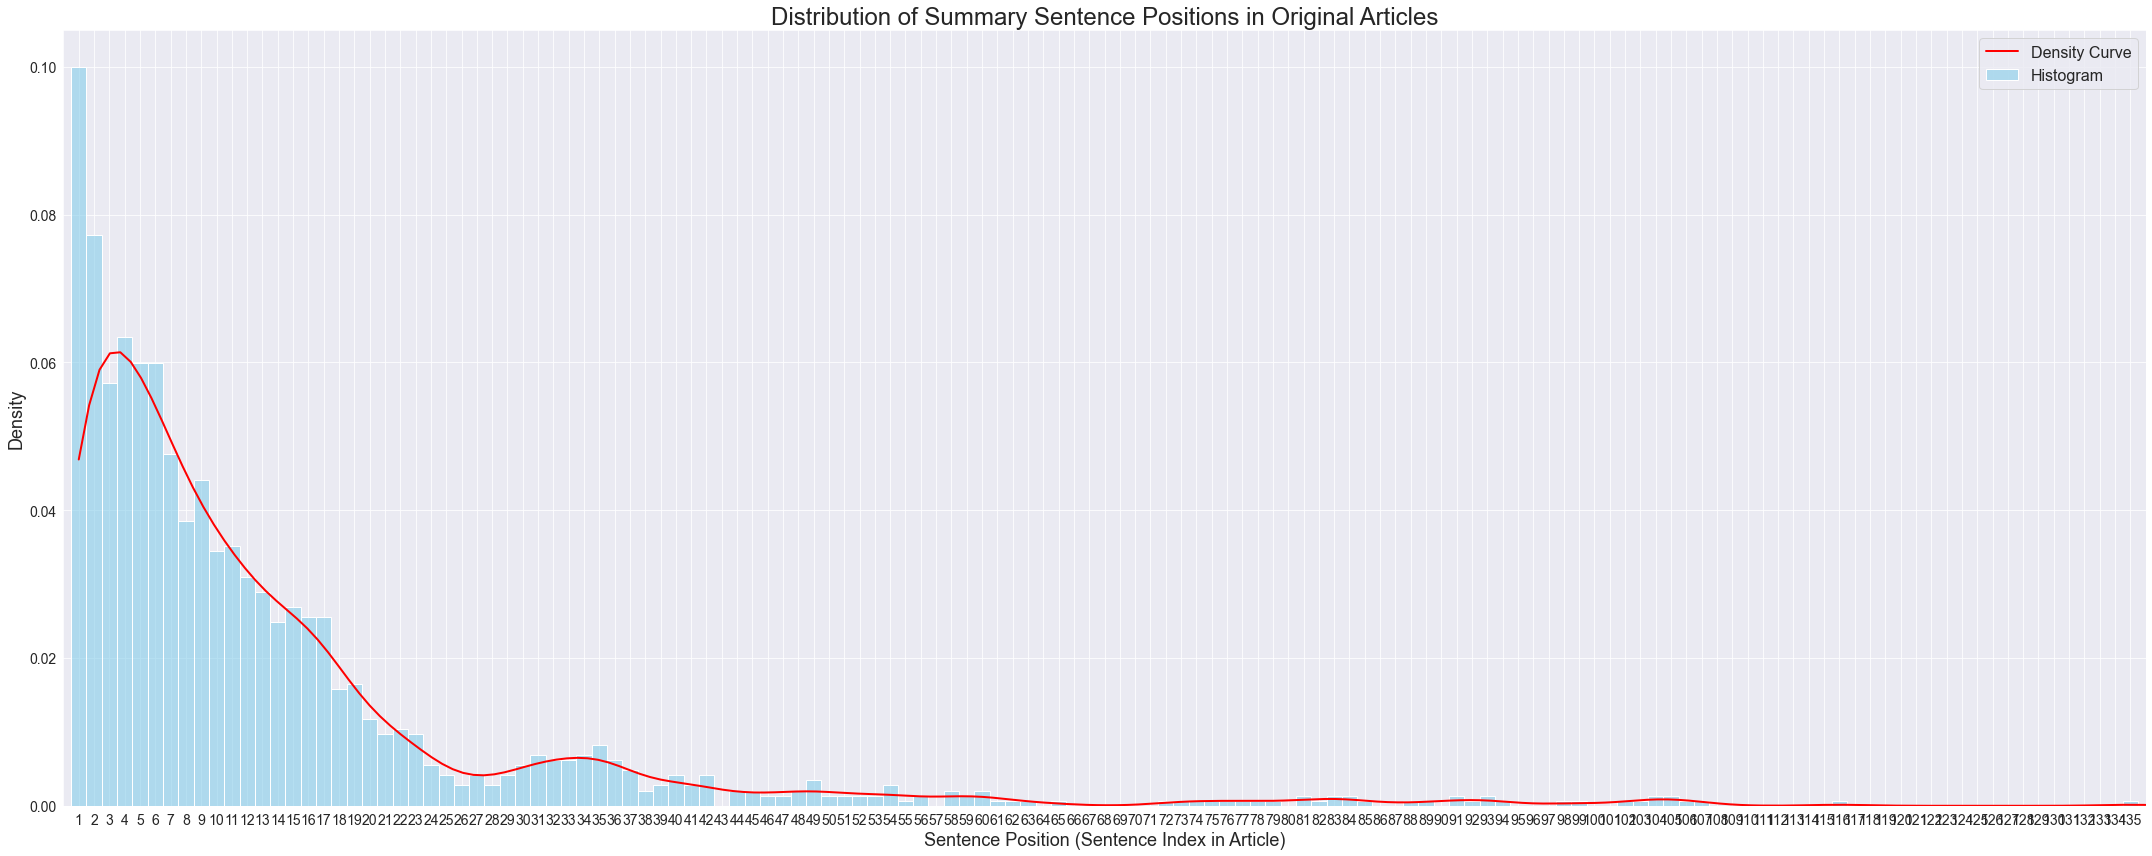

In [222]:
visualize_sentence_position_distribution(all_sentence_positions, output_file="enterprise_news_sentence_position_distribution.png")